In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import layers
import time
import timeit

## Helpers

In [14]:
class ETL:
    """
    ticker: str
    period: string
    test_size: float betwee 0 and 1
    n_input: int
    timestep: int
    Extracts data for stock with ticker `ticker` from yf api,
    splits the data into train and test sets by date,
    reshapes the data into np.array of shape [#weeks, 5, 1],
    converts our problem into supervised learning problem.
    """
    def __init__(self, ticker, test_size=0.2, period='max', n_input=5, timestep=5) -> None:
        self.ticker = ticker
        self.period = period
        self.test_size = test_size
        self.n_input = n_input
        self.df = self.extract_historic_data()
        self.timestep = timestep
        self.train, self.test = self.etl()
        self.X_train, self.y_train = self.to_supervised(self.train)
        self.X_test, self.y_test = self.to_supervised(self.test)

    def extract_historic_data(self) -> pd.Series:
        """
        gets historical data from yf api.
        """
        t = yf.Ticker(self.ticker)
        history = t.history(period=self.period)
        return history.Close

    def split_data(self) -> tuple:
        """
        Splits our pd.Series into train and test series with
        test series representing test_size * 100 % of data.
        """
        data = self.extract_historic_data()
        if len(data) != 0:
            train_idx = round(len(data) * (1-self.test_size))
            train = data[:train_idx]
            test = data[train_idx:]
            train = np.array(train)
            test = np.array(test)
            return train[:, np.newaxis], test[:, np.newaxis]
        else:
            raise Exception('Data set is empty, cannot split.')

    def window_and_reshape(self, data) -> np.array:
        """
        Reformats data into shape our model needs,
        namely, [# samples, timestep, # feautures]
        samples
        """
        NUM_FEATURES = 1
        samples = int(data.shape[0] / self.timestep)
        result = np.array(np.array_split(data, samples))
        return result.reshape((samples, self.timestep, NUM_FEATURES))

    def transform(self, train, test) -> np.array:
        train_remainder = train.shape[0] % self.timestep
        test_remainder = test.shape[0] % self.timestep
        if train_remainder != 0 and test_remainder != 0:
            train = train[train_remainder:]
            test = test[test_remainder:]
        elif train_remainder != 0:
            train = train[train_remainder:]
        elif test_remainder != 0:
            test = test[test_remainder:]
        return self.window_and_reshape(train), self.window_and_reshape(test)

    def etl(self) -> tuple[np.array, np.array]:
        """
        Runs complete ETL
        """
        train, test = self.split_data()
        return self.transform(train, test)

    def to_supervised(self, train, n_out=5) -> tuple:
        """
        Converts our time series prediction problem to a
        supervised learning problem.
        """
        # flatted the data
        data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
        X, y = [], []
        in_start = 0
        # step over the entire history one time step at a time
        for _ in range(len(data)):
            # define the end of the input sequence
            in_end = in_start + self.n_input
            out_end = in_end + n_out
            # ensure we have enough data for this instance
            if out_end <= len(data):
                x_input = data[in_start:in_end, 0]
                x_input = x_input.reshape((len(x_input), 1))
                X.append(x_input)
                y.append(data[in_end:out_end, 0])
                # move along one time step
                in_start += 1
        return np.array(X), np.array(y)

In [51]:
t = yf.Ticker("SPY")
history = t.history(period="max")
history.Close

Date
1993-01-29 00:00:00-05:00     24.840675
1993-02-01 00:00:00-05:00     25.017351
1993-02-02 00:00:00-05:00     25.070358
1993-02-03 00:00:00-05:00     25.335375
1993-02-04 00:00:00-05:00     25.441385
                                ...    
2023-12-14 00:00:00-05:00    470.104004
2023-12-15 00:00:00-05:00    469.329987
2023-12-18 00:00:00-05:00    471.970001
2023-12-19 00:00:00-05:00    474.839996
2023-12-20 00:00:00-05:00    468.260010
Name: Close, Length: 7780, dtype: float64

In [15]:
class PredictAndForecast:
    """
    model: tf.keras.Model
    train: np.array
    test: np.array
    Takes a trained model, train, and test datasets and returns predictions
    of len(test) with same shape.
    """
    def __init__(self, model, train, test, n_input=5) -> None:
        self.model = model
        self.train = train
        self.test = test
        self.n_input = n_input
        self.predictions = self.get_predictions()

    def forecast(self, history) -> np.array:
        """
        Given last weeks actual data, forecasts next weeks prices.
        """
        # flatten data
        data = np.array(history)
        data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
        # retrieve last observations for input data
        input_x = data[-self.n_input:, :]
        # reshape into [1, n_input, 1]
        input_x = input_x.reshape((1, len(input_x), input_x.shape[1]))
        # forecast the next week
        yhat = self.model.predict(input_x, verbose=0)
        # we only want the vector forecast
        yhat = yhat[0]
        return yhat

    def get_predictions(self) -> np.array:
        """
        compiles models predictions week by week over entire
        test set.
        """
        # history is a list of weekly data
        history = [x for x in self.train]
        # walk-forward validation over each week
        predictions = []
        for i in range(len(self.test)):
            yhat_sequence = self.forecast(history)
            # store the predictions
            predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
            history.append(self.test[i, :])
        return np.array(predictions)

In [16]:
class Evaluate:

  def __init__(self, actual, predictions) -> None:
    self.actual = actual
    self.predictions = predictions
    self.var_ratio = self.compare_var()
    self.mape = self.evaluate_model_with_mape()

  def compare_var(self):
    return abs( 1 - (np.var(self.predictions) / np.var(self.actual)))

  def evaluate_model_with_mape(self):
    return mean_absolute_percentage_error(self.actual.flatten(), self.predictions.flatten())

In [29]:
data = ETL('SPY')

## Transformers

In [18]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow.keras import layers

# Function to create a single transformer encoder block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):
  """
  Creates a single transformer encoder block

  Args:
    inputs: Input to the transformer encoder
    head_size: Dimensionality of the query, key, and value tensors
    num_heads: Number of attention heads
    ff_dim: Number of kernels
    dropout: Dropout rate
    epsilon: Small constant to add to the denominator in layer normalization
    attention_axes: How attention is applied over input data, usually 1 means attention over 1d embedding
    kernel_size: Kernel size for the convolution layers

  Returns:
    Output tensor of the transformer encoder block.
  """

  # Layer normalization followed by Multi-head attention
  x = layers.LayerNormalization(epsilon=epsilon)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs  # stablize output to prevent gradient vanishing (skip connection)

  # Feed-forward part of the transformer block
  x = layers.LayerNormalization(epsilon=epsilon)(res)
  # Might be smoothing by extracting features in small windows
  x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
  return x + res  # stablize output to prevent gradient vanishing (skip connection)

# Function to create the full Transformer model
def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0, attention_axes=None, epsilon=1e-6, kernel_size=1):
  """
  Stacking multiple transformer encoder blocks

  Args:
    num_trans_blocks: Number of transformer blocks to stack.
    mlp_units: List of units for each dense layer in the MLP at the end.

  Returns:
    A Keras Model instance.
  """

  # Fixed input and output dimensions for this model
  n_timesteps, n_features, n_outputs = 5, 1, 5
  inputs = tf.keras.Input(shape=(n_timesteps, n_features))

  x = inputs
  # Stacking the specified number of transformer blocks
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)

  # Global average pooling followed by MLP
  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

  # Output layer
  outputs = layers.Dense(n_outputs)(x)
  return tf.keras.Model(inputs, outputs)


In [19]:
transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)
transformer.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 5, 1)]               0         []                            
                                                                                                  
 layer_normalization_32 (La  (None, 5, 1)                 2         ['input_5[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_16 (M  (None, 5, 1)                 3585      ['layer_normalization_32[0][0]
 ultiHeadAttention)                                                 ',                            
                                                                     'layer_normalization_32

In [20]:
def fit_transformer(transformer: tf.keras.Model):
  """
  Compiles and fits our transformer.
  """
  transformer.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mae", 'mape'])

  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
  start = time.time()
  hist = transformer.fit(data.X_train, data.y_train, batch_size=32, epochs=25, verbose=1, callbacks=callbacks)
  print(time.time() - start)
  return hist


In [30]:
hist = fit_transformer(transformer)

Epoch 1/25
195/195 [==============================] - 15s 18ms/step - loss: 17.0463 - mae: 2.9513 - mape: 3.1911
Epoch 2/25
195/195 [==============================] - 3s 18ms/step - loss: 16.7074 - mae: 2.9282 - mape: 3.1964
Epoch 3/25
195/195 [==============================] - 4s 20ms/step - loss: 16.0146 - mae: 2.8868 - mape: 3.1454
Epoch 4/25
195/195 [==============================] - 5s 26ms/step - loss: 15.4574 - mae: 2.8225 - mape: 3.0779
Epoch 5/25
195/195 [==============================] - 3s 17ms/step - loss: 15.4585 - mae: 2.8232 - mape: 3.0821
Epoch 6/25
195/195 [==============================] - 4s 19ms/step - loss: 15.9487 - mae: 2.8813 - mape: 3.1618
Epoch 7/25
195/195 [==============================] - 4s 20ms/step - loss: 14.7277 - mae: 2.7690 - mape: 3.0332
Epoch 8/25
195/195 [==============================] - 3s 17ms/step - loss: 16.4912 - mae: 2.9064 - mape: 3.1508
Epoch 9/25
195/195 [==============================] - 4s 18ms/step - loss: 16.2173 - mae: 2.9166 - mape

## Prediction

In [31]:
%%time
#start = time.time()
transformer_preds = PredictAndForecast(transformer, data.train, data.test)
#print(time.time() - start)

CPU times: user 19.1 s, sys: 533 ms, total: 19.7 s
Wall time: 20 s


In [32]:
transformer_evals = Evaluate(data.test, transformer_preds.predictions)
transformer_evals.mape

0.027919665916218597

In [33]:
transformer_evals.var_ratio

0.04992703061210646

## Plot

In [48]:
def plot_results(test, preds, df, title_suffix=None, xlabel='SPY Price'):
  """
  Plots training data in blue, predictions in yellow
  """
  fig, ax = plt.subplots(figsize=(20,6))
  # x = df.Close[-498:].index
  plot_test = test[1:]
  plot_preds = preds[1:]
  x = df[-(plot_test.shape[0]*plot_test.shape[1]):].index
  plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  ax.plot(x, plot_test, label='actual')
  ax.plot(x, plot_preds, label='preds')
  if title_suffix==None:
    ax.set_title('Predictions vs. Actual')
  else:
    ax.set_title(f'Predictions vs. Actual, {title_suffix}')
  ax.set_xlabel('Date')
  ax.set_ylabel(xlabel)
  ax.legend()
  plt.show()

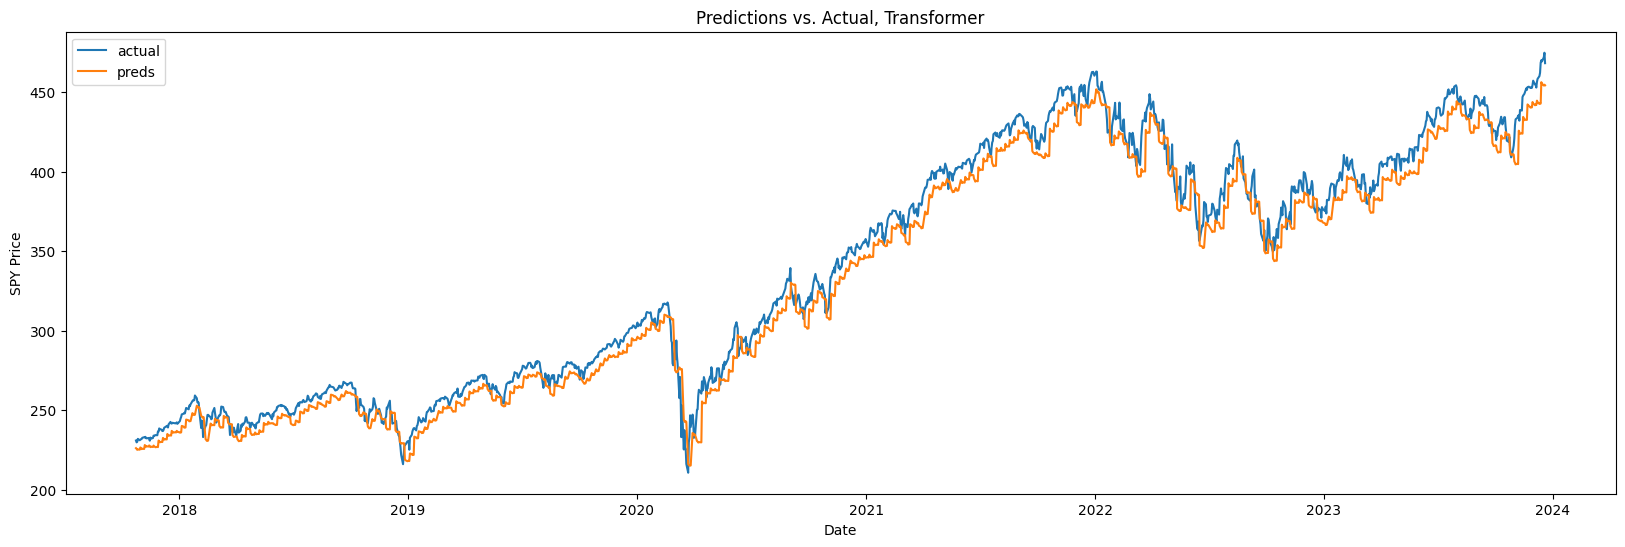

In [49]:
plot_results(data.test, transformer_preds.predictions, data.df, title_suffix='Transformer')